In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.style.use('seaborn-paper')
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

from ttcrpy.rgrid import Grid3d

# Example 1 - 3D layered model

The model contains 10 horizontal layers of homogeneous velocity, with layer velocity increasing linearly downward.  The rectilinar grid will contain 40 x 40 x 40 voxels.

In [2]:
N = 40        # number if voxels in each direction
dx = 0.5      # cell size

# coordinates of the nodes
xn = np.arange(0, (N+1)*dx, dx)
yn = np.arange(0, (N+1)*dx, dx)
zn = np.arange(0, (N+1)*dx, dx)

# create grid with default values (by default, slowness is defined for cells)
grid = Grid3d(xn, yn, zn)

# values of slowness along vertical axis, define first vertical gradient
a = 1.0
V20 = 3.0
b = (V20-a)/20.0
# fill array
slowness = np.empty((N,))
for n in range(N):
    z = 2*int(zn[n]/2) + 1
    slowness[n] = 1.0 / (a+b*z)
# repeat for all x & y locations
slowness = np.tile(slowness, N*N)

# Assign slowness to grid
grid.set_slowness(slowness)

# Save to VTK format to visualize
grid.to_vtk({'Velocity': 1./slowness}, 'example1')

The model looks like this

<img src="figs/example1_velocity.png"  width="600"/>

Let's now compute traveltimes and raypaths for 1 source.

In [3]:
# Define the source location
src = np.array([[0.5, 0.5, 0.5]])

# Define some receivers, first a spread in the horizontal
rcv = np.c_[np.arange(1.5, 20.0),
            np.arange(1.5, 20.0),
            0.5+np.zeros((19,))]
# Add receivers in a "borehole"
rcv = np.r_[rcv, np.c_[19.5+np.zeros((19,)),
                       19.5+np.zeros((19,)),
                       np.arange(1.5, 20.0)]]

# Compute traveltimes and raypaths
ref = time.time()
tt, rays = grid.raytrace(src, rcv, return_rays=True)
compute_time1 = time.time() - ref

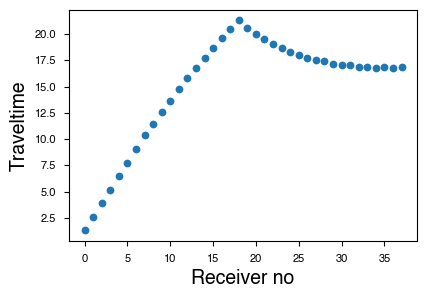

In [4]:
# Check traveltime values
plt.figure(figsize=(4.5,3))
plt.plot(tt, 'o')
plt.xlabel('Receiver no', fontsize=14)
plt.ylabel('Traveltime', fontsize=14)
plt.savefig('figs/example1_tt_fsm.pdf', bbox_inches='tight')

# Save raypaths
grid.to_vtk({'raypaths for shot no 1': rays}, 'example1_rays')

By default, the Fast-Sweeping method is used and the raypaths are obtained by using the direction of the gradient of traveltime, from the receivers toward the source.  For the case here, rays should be straight inside the layers, and the path of head waves should follow the interfaces.

<img src="figs/rays_fsm.png"  width="600"/>

The Shortest-Path method is more useful for this scenario, let's see what we get from it.

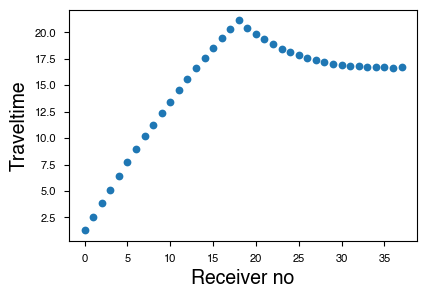

In [5]:
# use Shortest-Path method with default number of secondary node (5)
grid_spm = Grid3d(xn, yn, zn, method='SPM')

# Compute traveltimes and raypaths
ref = time.time()
tt, rays = grid_spm.raytrace(src, rcv, slowness=slowness, return_rays=True)
compute_time2 = time.time() - ref

# Check traveltime values
plt.figure(figsize=(4.5,3))
plt.plot(tt, 'o')
plt.xlabel('Receiver no', fontsize=14)
plt.ylabel('Traveltime', fontsize=14)
plt.savefig('figs/example1_tt_spm.pdf', bbox_inches='tight')

# Save raypaths
grid.to_vtk({'raypaths for shot no 1': rays}, 'example1_rays_spm')

Now, the rays look better (shown in green).

<img src="figs/rays_spm.png"  width="600"/>

The cost for this improvement is compute time:

In [6]:
print('Compute time\n\n    FSM:  {0:2.1f}\n    SPM: {1:2.1f}\n'.format(compute_time1, compute_time2))
print('a ratio of 1:{0:2.1f}'.format(compute_time2/compute_time1))

Compute time

    FSM:  2.6
    SPM: 51.0

a ratio of 1:19.3


We can see that the FSM is much faster, this is why it is set as the default method.  The last illustrated functionnality if how to obtain the Jacobian matrix, which is used in inversion to compute model perturbations.
Besides, provided that model perturbations are small between
iterations, this matrix can be assumed to remain constant for a few
iterations.  In such cases, traveltimes are obtained by a fast
matrix-vector product.  

In [7]:
tt, L = grid_spm.raytrace(src, rcv, slowness=slowness, compute_L=True)

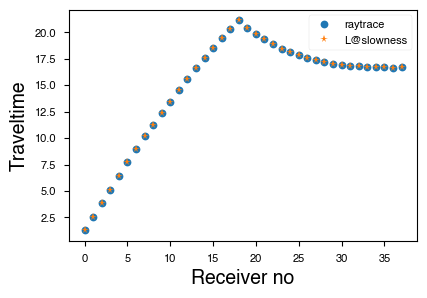

Difference:  1.4582431819269342e-13
Compute time:  0.0003619194030761719


In [8]:
ref = time.time()
tt2 = L@slowness
compute_time3 = time.time() - ref
plt.figure(figsize=(4.5,3))
plt.plot(tt, 'o', label='raytrace')
plt.plot(tt2, '*', label='L@slowness')
plt.xlabel('Receiver no', fontsize=14)
plt.ylabel('Traveltime', fontsize=14)
plt.legend()
plt.show()

print('Difference: ', np.linalg.norm(tt - tt2))
print('Compute time: ', compute_time3)